In [1]:
import numpy as np
import torch
from utility import predict_func_2input, load_best_model
from smalltransformer import SmallTransformer
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.cluster import KMeans

In [128]:
# Model
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_ST_v3.0.pth')

Best model loaded.


In [3]:
# 特征
with open('/kaggle/input/train_preprocessed.pkl', 'rb') as file:
    full_predictions_spectra = pickle.load(file)
full_whitelight_s_train = np.array([
    predict_spectra(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 预测每个星球的白光缩放比例S
full_light_alpha_train = np.array([
    cal_flux(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 计算每个星球的各个波段的吸收峰相对面积

In [4]:
# 目标
train_solution = np.loadtxt(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    delimiter=',',
    skiprows=1)
targets = train_solution[:, 1:]
newtarget = targets / full_whitelight_s_train[:, np.newaxis]
targets_tensor = torch.tensor(newtarget).float()
target_min = targets_tensor.min()
target_max = targets_tensor.max()
full_targets_normalized = (targets_tensor - target_min) / (target_max -
                                                           target_min)

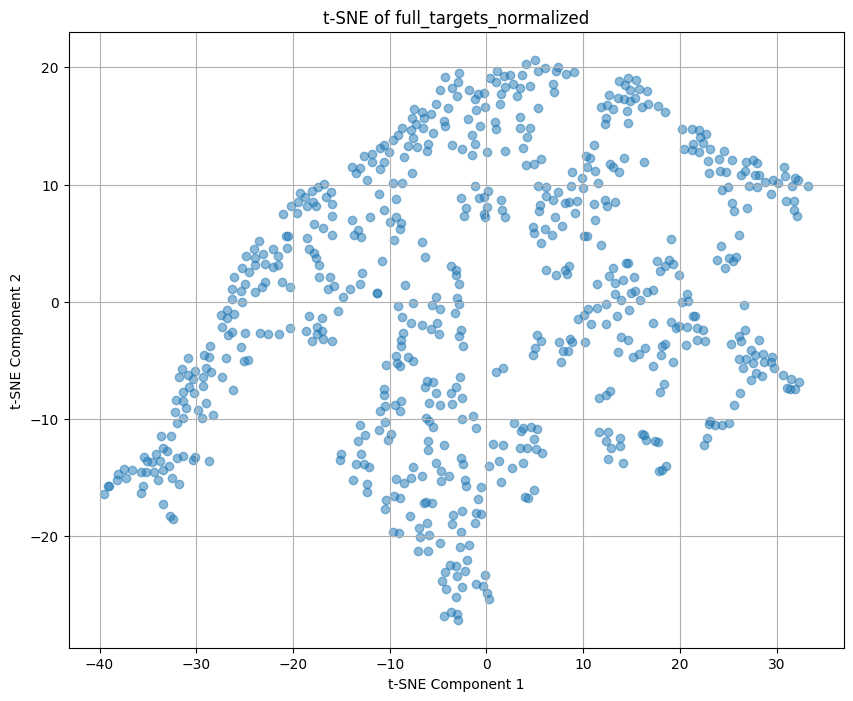

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用 t-SNE 将数据降维到二维
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(full_targets_normalized)

# 绘制二维平面上的数据点
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title("t-SNE of full_targets_normalized")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

In [31]:
# 使用 K-means 聚类
n_clusters = 16  # 你可以根据需要调整聚类数量
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42).fit(full_targets_normalized)
cluster_labels = kmeans.labels_

c:\veighna_studio\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
np.random.seed(21)
# 初始化存储采样的索引列表
sampled_indices = []
samples_per_cluster = 640 // n_clusters  # 每个聚类中目标样本数量

for cluster in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # 如果样本数量不足，则进行上采样
    if len(cluster_indices) < samples_per_cluster:
        temp_samples = cluster_indices.tolist()
        sampled_indices.extend(temp_samples)
        remaining_samples = samples_per_cluster - len(cluster_indices)
        sampled_indices.extend(
            np.random.choice(cluster_indices, remaining_samples, replace=True))
    else:
        # 样本数量充足时正常采样
        sampled_indices.extend(
            np.random.choice(cluster_indices,
                             samples_per_cluster,
                             replace=False))

print(f"Sampled indices: {len(sampled_indices)}")

Sampled indices: 640


In [33]:
mask = np.ones(full_predictions_spectra.shape[0], dtype=bool)
mask[sampled_indices] = False
predictions_spectra_test = full_predictions_spectra[mask]
min_values = predictions_spectra_test.min(axis=(1, 2), keepdims=True)
max_values = predictions_spectra_test.max(axis=(1, 2), keepdims=True)
normalized_spectra = (predictions_spectra_test - min_values) / (max_values -
                                                                min_values)
data_test_reshaped = torch.tensor(normalized_spectra).float()

In [34]:
predictions_spectra_test.shape

(340, 187, 283)

In [134]:
whitelight_s_test = full_whitelight_s_train[mask]
light_alpha_test = full_light_alpha_train[mask]
light_alpha_test = torch.tensor(light_alpha_test).float()

In [135]:
all_predictions = predict_func_2input(model,
                                      data_test_reshaped,
                                      light_alpha_test,
                                      batch_size=1)
all_predictions = all_predictions * (target_max - target_min) + target_min
all_predictions = all_predictions.numpy()

In [136]:
all_predictions.min(), all_predictions.max()

(0.80974156, 1.4307194)

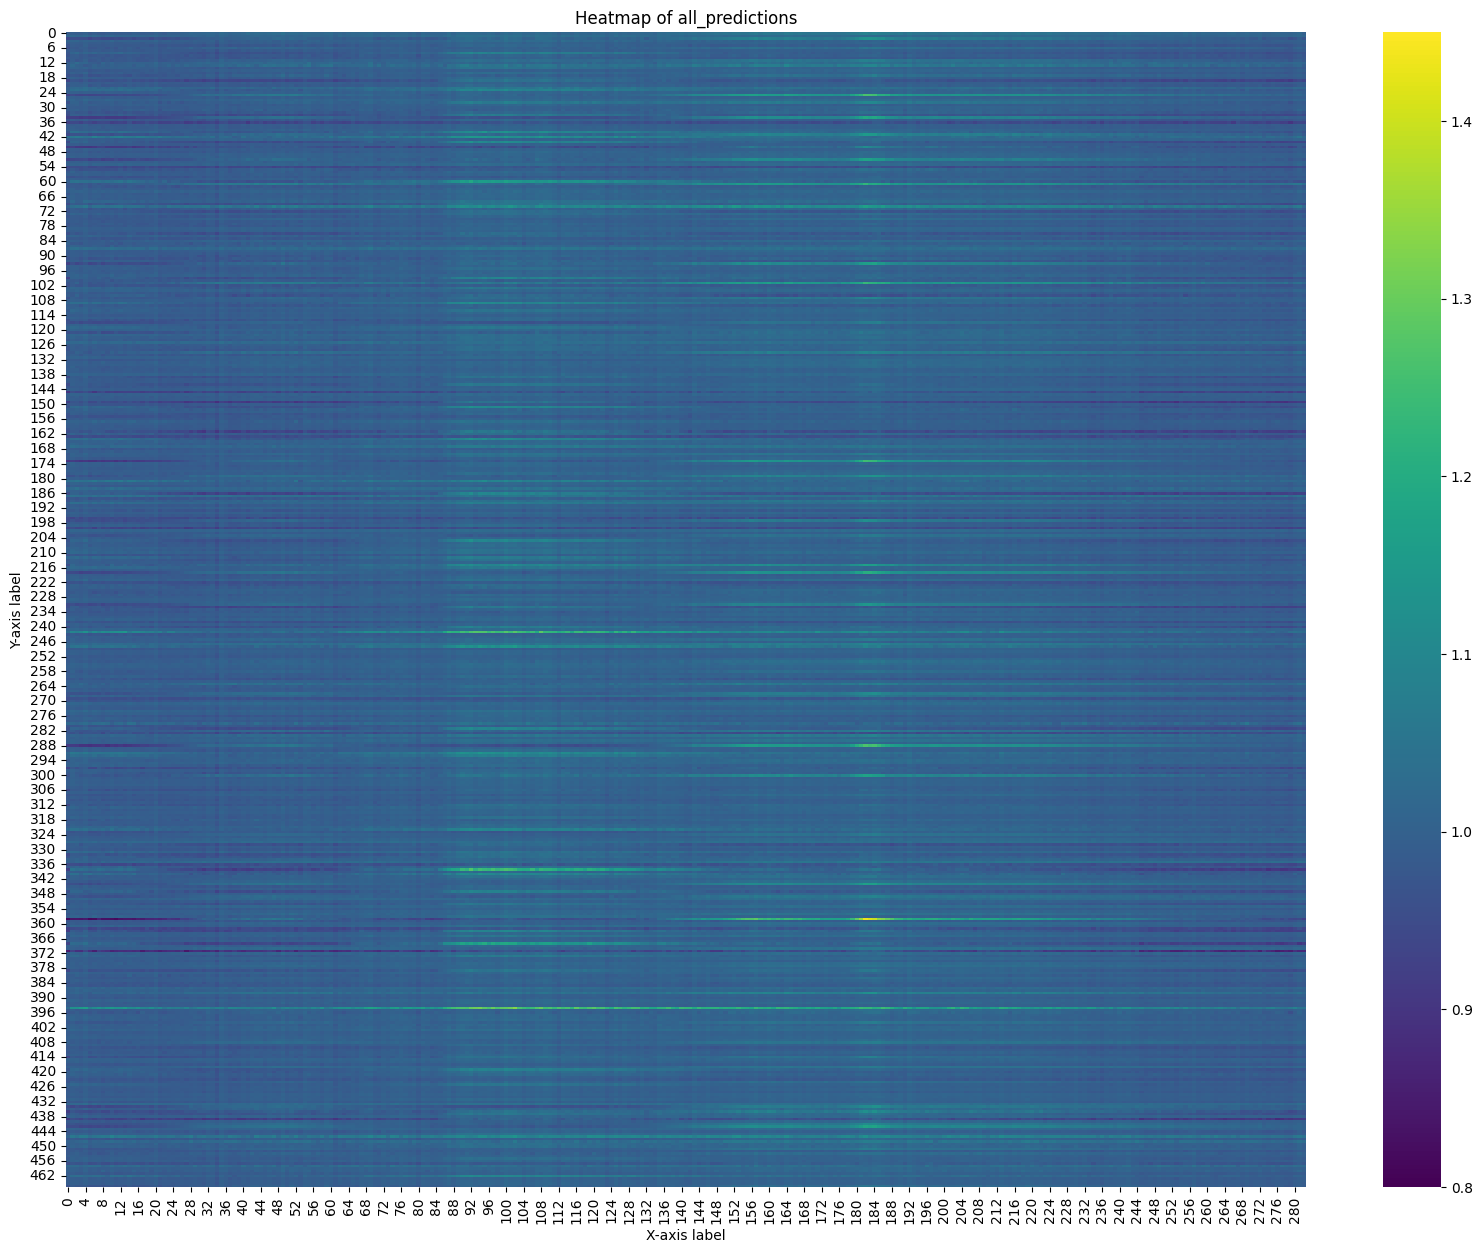

In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(all_predictions,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of all_predictions")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [138]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [139]:
reviewtarget = targets[mask] / whitelight_s_test[:, np.newaxis]

In [140]:
reviewtarget.min(), reviewtarget.max()

(0.7670326289315522, 1.3456985276354418)

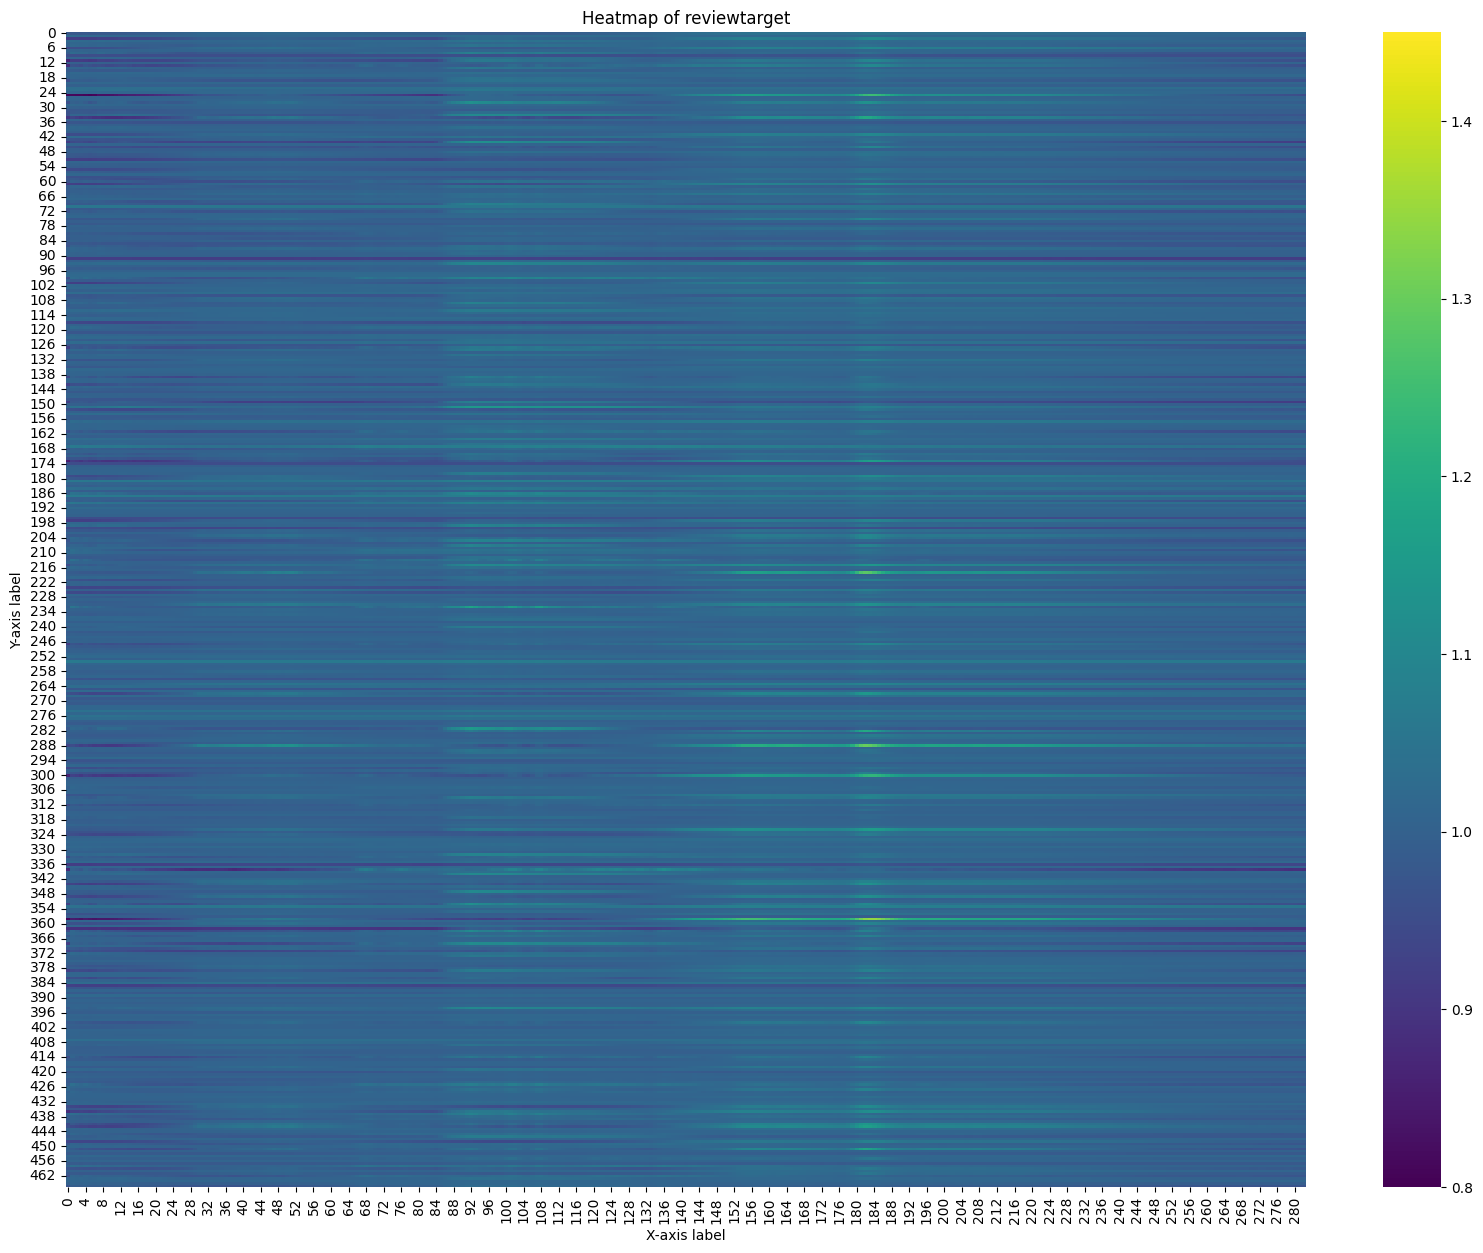

In [141]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(reviewtarget,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of reviewtarget")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [142]:
reviewtarget.min(), reviewtarget.max()

(0.7670326289315522, 1.3456985276354418)

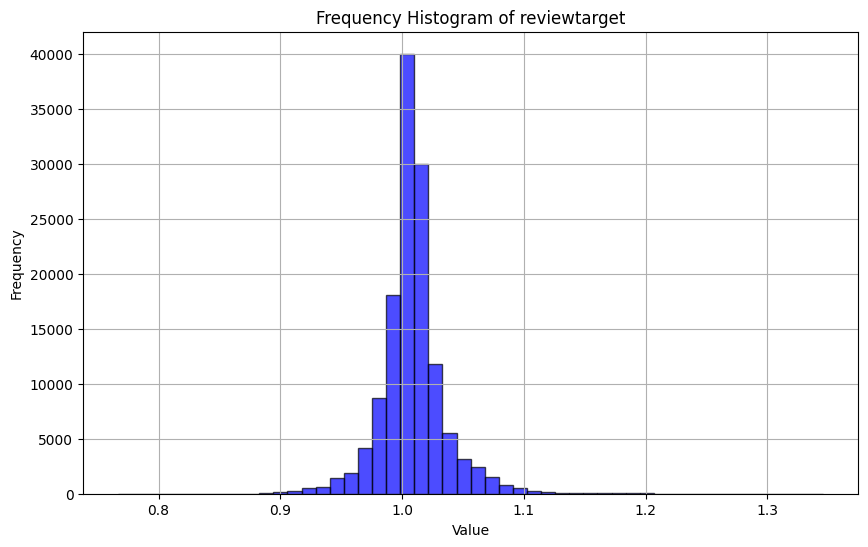

In [143]:
reviewtarget_flat = reviewtarget.flatten()
plt.figure(figsize=(10, 6))
plt.hist(reviewtarget_flat,
         bins=50,
         color='blue',
         edgecolor='black',
         alpha=0.7)
plt.title("Frequency Histogram of reviewtarget")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [144]:
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]

In [153]:
all_predictions.shape

(467, 283)

In [145]:
targets = targets[mask]

In [154]:
targets.shape

(467, 283)

In [170]:
print(f"# R2 score: {r2_score(targets, all_predictions):.6f}")
sigma_pred = mean_squared_error(targets, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.998911
# Root mean squared error: 0.000058


In [156]:
squared_errors = (targets - all_predictions)**2

# 计算每一列的均方误差（MSE）
mse = np.mean(squared_errors, axis=0)

# 计算每一列的均方根误差（RMSE）
rmse = np.sqrt(mse)

print("RMSE for each column:", rmse)

RMSE for each column: [6.55321233e-05 5.38823150e-05 5.50416315e-05 6.40618593e-05
 4.91879993e-05 6.54178975e-05 5.94431315e-05 6.08520830e-05
 7.43549631e-05 6.31856090e-05 5.69673407e-05 6.86504372e-05
 6.36672255e-05 6.37082491e-05 5.18563810e-05 6.16535964e-05
 5.99408834e-05 6.48017549e-05 5.53388881e-05 5.90302871e-05
 4.48922698e-05 7.54942628e-05 6.17353692e-05 6.55195306e-05
 6.57081375e-05 6.19458651e-05 6.09921712e-05 6.79522875e-05
 6.24132379e-05 5.69006755e-05 7.38102914e-05 8.42220396e-05
 5.27127667e-05 5.79909163e-05 1.06203134e-04 4.46489308e-05
 6.18198884e-05 8.48286708e-05 7.61647756e-05 8.36603300e-05
 6.19705057e-05 7.73980367e-05 5.37105238e-05 5.56845036e-05
 5.62515502e-05 7.11512618e-05 5.65986603e-05 7.51606758e-05
 6.84875041e-05 4.78077318e-05 8.10622258e-05 6.26504863e-05
 6.73949425e-05 7.46970915e-05 4.10943085e-05 4.54709352e-05
 5.71527107e-05 4.92664047e-05 6.98098240e-05 4.56697725e-05
 4.66229165e-05 8.09424651e-05 5.19284612e-05 6.19551227e-05
 6

In [148]:
len(rmse)

283

In [167]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info[mask].index,
                        sigma_pred=np.tile(
                            np.where(test_adc_info[mask][['star']] <= 1,
                                     0.000117, 0.000117), (1, 283)))

In [168]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels[mask].values.mean(),
                              naive_sigma=train_labels[mask].values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.545


In [169]:
best_gll = 0
best_sigma = 0
for i in range(50, 200):
    sigma_test = i * 0.000001
    sub_df = postprocessing(all_predictions,
                            wavelengths,
                            test_adc_info[mask].index,
                            sigma_pred=np.tile(
                                np.where(test_adc_info[mask][['star']] <= 1,
                                         sigma_test, 0.000117), (1, 283)))
    gll_score = competition_score(train_labels[mask].copy().reset_index(),
                                  sub_df.copy().reset_index(),
                                  naive_mean=train_labels[mask].values.mean(),
                                  naive_sigma=train_labels[mask].values.std(),
                                  sigma_true=0.00001)
    if gll_score > best_gll:
        best_gll = gll_score
        best_sigma = sigma_test
print(f"# Best sigma: {best_sigma:.6f}")
print(f"# Best GLL: {best_gll:.3f}")

# Best sigma: 0.000059
# Best GLL: 0.600


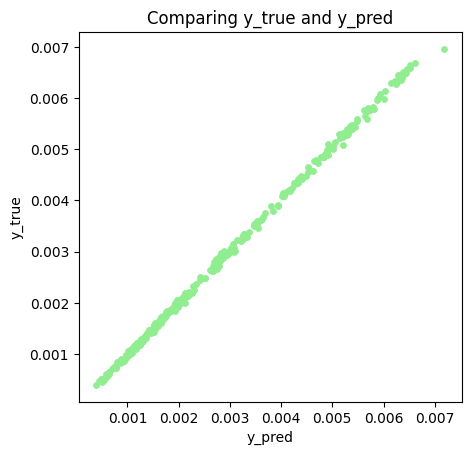

In [104]:
import matplotlib.pyplot as plt

col = 1
plt.scatter(all_predictions[:, col], targets[:, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

Outlier lens: 6
Outliers: (array([ 15,  86, 184, 204, 283, 328], dtype=int64),)


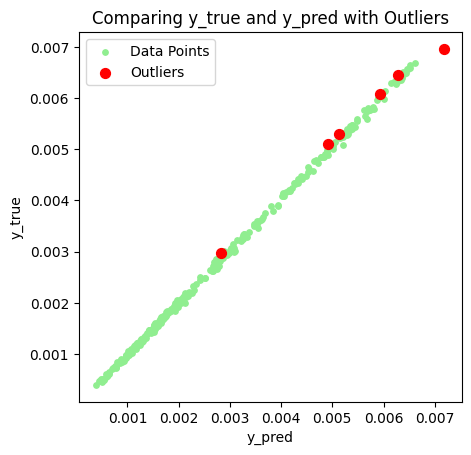

In [105]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

col = 1
# 假设 predict_targets 和 targets 是 numpy 数组
errors = np.abs(all_predictions[:, col] - targets[:, col])
z_scores = np.abs(stats.zscore(errors))

# 设置 Z-score 阈值，通常为 3
threshold = 3
outliers = np.where(z_scores > threshold)

# 打印异常值索引
print("Outlier lens:", len(outliers[0]))
print("Outliers:", outliers)
plt.scatter(all_predictions[:, col],
            targets[:, col],
            s=15,
            c='lightgreen',
            label='Data Points')
plt.scatter(all_predictions[outliers[0], col],
            targets[outliers[0], col],
            s=50,
            c='red',
            label='Outliers')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred with Outliers')
plt.legend()
plt.show()

In [106]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - targets[:, col])
    z_scores = np.abs(stats.zscore(errors))
    outliers = np.where(z_scores > threshold)[0]
    normals = np.where(z_scores <= threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 184 is an outlier in 234 columns and normal in columns: [53, 87, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 107, 108, 109, 110, 111, 112, 113, 114, 116, 121, 125, 127, 131, 135, 154, 155, 157, 158, 159, 164, 167, 180, 181, 182, 183, 184, 185, 186, 187, 192, 210, 218]
Data point 233 is an outlier in 180 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 59, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 251, 252, 254, 255, 256, 257, 260, 261, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282]
Data point 204 is an outlier in 172 columns and normal in columns: [0, 3, 5, 6, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 30, 31, 34, 37, 38, 39, 41, 45, 48,

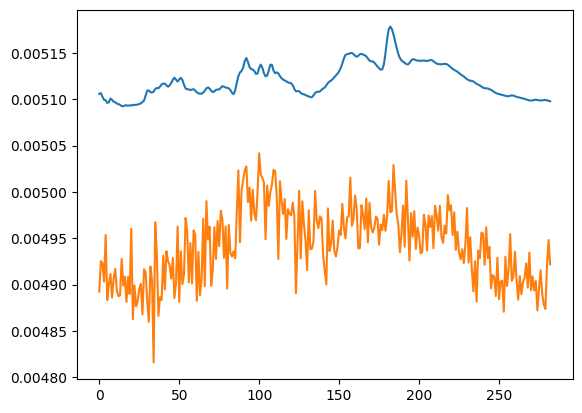

In [121]:
planet = 184
plt.plot(targets[planet, :])
plt.plot(all_predictions[planet, :])